# Generate routes

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.cluster import KMeans

In [3]:
data_stops = pd.read_csv('data/uni_molde_v3.csv', sep=';')

# data_stops.loc[data_stops['stop_completed_at'].isna(), 'stop_completed_at'] = "-1"
# data_stops.loc[data_stops['stop_arrived_at'].isna(), 'stop_arrived_at'] = "-1"

print(data_stops.isnull().sum())


sorted_data_stops = data_stops.sort_values(by='stop_dispatched_at', ascending=True)
sorted_data_stops = sorted_data_stops.reset_index(drop=True)
sorted_data_stops['day_of_week'] = pd.to_datetime(sorted_data_stops['stop_arrived_at']).dt.day_name()
sorted_data_stops['date'] = pd.to_datetime(sorted_data_stops['stop_arrived_at']).dt.date

#clustering
locations_df = sorted_data_stops[['current_lat', 'current_lng']]
kmeans = KMeans(n_clusters=1000, random_state=42)
kmeans.fit(locations_df)
sorted_data_stops['cluster'] = kmeans.labels_ + 1

sorted_data_stops['location_id_craft'] = sorted_data_stops.groupby(['current_lat', 'current_lng']).ngroup()+1
with open('output.txt', 'w') as f:
    print(sorted_data_stops.to_string(), file=f)
print('number of groups', sorted_data_stops['location_id_craft'].nunique())

# data_stops_day= sorted_data_stops[sorted_data_stops['day_of_week'] == "Wednesday"]
grouped_df = sorted_data_stops.groupby('driver_workday_id')[['driver_id', 'location_type_id', 'address_id', 'stop_dispatched_at', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'stop_completed_at', 'cluster', 'location_id_craft','day_of_week', 'date']].apply(lambda x: pd.Series({
    'driver_id': x['driver_id'].tolist(),
    'location_type_id': x['location_type_id'].tolist(),
    'planned_route_location': x['address_id'].tolist(),
    'stop_dispatched_at': x['stop_dispatched_at'].tolist(),
    'stop_arrived_at': x['stop_arrived_at'].tolist(),
    'stop_earliest': x['stop_earliest'].tolist(),
    'stop_latest': x['stop_latest'].tolist(),
    'current_lat': x['current_lat'].tolist(),
    'current_lng': x['current_lng'].tolist(),
    'stop_completed_at': x['stop_completed_at'].tolist(),
    'planned_route_cluster': x['cluster'].tolist(),
    'planned_route_craft': x['location_id_craft'].tolist(),
    'day_of_week': x['day_of_week'].tolist(),
    'date': x['date'].tolist()
})).reset_index()
grouped_df

   location_type_id  location_is_depot   count
0                 1              False   13484
1                 1               True   38596
2                 2              False  292363
3                 2               True    7940


In [3]:
from geopy.distance import geodesic
import pandas as pd

# Function to calculate distance between two coordinates
def calculate_distance(row):
    distances = []
    for i in range(len(row['planned_route_craft'])-1):
        coords_1 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i], ['current_lng']].values[0][0])
        coords_2 = (sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lat']].values[0][0],
                     sorted_data_stops.loc[sorted_data_stops['location_id_craft'] == row['planned_route_craft'][i+1], ['current_lng']].values[0][0])
        distances.append(geodesic(coords_1, coords_2).miles)
    return distances

# Create a new column 'distance_route' in 'final_routes'
grouped_df['distance_route'] = grouped_df.apply(calculate_distance, axis=1)

In [4]:
grouped_df

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route
0,297900,"[1255, 1255, 1255, 1255, 1255, 1255, 1255, 125...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 118973, 118854, 118820, 118623, 11909...","[2024-01-01 19:41:35.136881+00, 2024-01-01 19:...","[2024-01-01 22:14:16.454324+00, 2024-01-01 23:...","[2024-01-01 19:00:00+00, 2024-01-01 23:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 03:00:00+0...","[55.647, 55.667, 55.677, 55.676, 55.671, 55.66...","[12.152, 12.526, 12.566, 12.562, 12.561, 12.56...","[2024-01-01 22:14:54.872731+00, 2024-01-01 23:...","[766, 597, 919, 560, 560, 404, 811, 404, 404, ...","[886, 1060, 1171, 1160, 1098, 1057, 1078, 1065...","[Monday, Monday, Monday, Tuesday, Monday, Tues...","[2024-01-01, 2024-01-01, 2024-01-01, 2024-01-0...","[14.693059943223329, 1.7100561195423718, 0.170..."
1,297906,"[1195, 1195, 1195, 1195, 1195, 1195, 1195]","[1, 2, 2, 2, 2, 2, 2]","[122267, 120295, 120297, 118930, 120298, 13328...","[2024-01-01 19:42:05.147145+00, 2024-01-01 19:...","[2024-01-01 20:50:17.003744+00, 2024-01-02 02:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.662, 55.662, 55.673, 55.662, 55.65...","[12.152, 12.361, 12.363, 12.394, 12.369, 12.36...","[2024-01-01 20:50:29.721122+00, 2024-01-02 02:...","[766, 723, 723, 263, 116, 116, 416]","[886, 1018, 1019, 1116, 1020, 989, 1051]","[Monday, Tuesday, Tuesday, Tuesday, Tuesday, T...","[2024-01-01, 2024-01-02, 2024-01-02, 2024-01-0...","[8.240469050783075, 0.0782134907119265, 1.4312..."
2,297908,"[1176, 1176, 1176, 1176, 1176, 1176, 1176, 117...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[122267, 120515, 119217, 119215, 119170, 13445...","[2024-01-01 21:25:47.230131+00, 2024-01-01 21:...","[2024-01-01 23:06:27.627368+00, 2024-01-02 01:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.62, 55.636, 55.632, 55.627, 55.609...","[12.152, 12.029, 12.045, 12.055, 12.097, 12.08...","[2024-01-01 23:06:36.064172+00, 2024-01-02 01:...","[766, 625, 785, 376, 506, 626, 854, 854, 854, ...","[886, 721, 790, 772, 737, 695, 970, 970, 960, ...","[Monday, Tuesday, Tuesday, Tuesday, Tuesday, T...","[2024-01-01, 2024-01-02, 2024-01-02, 2024-01-0...","[5.163323971103205, 1.2717651170406523, 0.4792..."
3,297911,"[1197, 1197, 1197, 1197, 1197, 1197, 1197, 119...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 145327, 133259, 133259, 133259, 13325...","[2024-01-01 19:42:59.704147+00, 2024-01-01 19:...","[2024-01-02 00:09:15.241119+00, 2024-01-02 04:...","[2024-01-02 00:00:00+00, 2024-01-02 04:30:00+0...","[2024-01-02 22:00:00+00, 2024-01-02 08:00:00+0...","[55.647, 54.651, 54.666, 54.666, 54.666, 54.66...","[12.152, 11.376, 11.333, 11.333, 11.333, 11.33...","[2024-01-02 00:09:21.131516+00, 2024-01-02 04:...","[766, 188, 39, 39, 39, 39, 39, 39, 957, 188]","[886, 5, 20, 20, 20, 20, 20, 20, 10, 3]","[Tuesday, Tuesday, Tuesday, Tuesday, Tuesday, ...","[2024-01-02, 2024-01-02, 2024-01-02, 2024-01-0...","[75.44459145823315, 2.0124277859574424, 0.0, 0..."
4,297919,"[1218, 1218, 1218, 1218, 1218, 1218, 1218, 121...","[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[122267, 119426, 118790, 119069, 118805, 11885...","[2024-01-01 19:46:51.16173+00, 2024-01-01 19:4...","[2024-01-01 23:05:52.039818+00, 2024-01-02 01:...","[2024-01-01 19:00:00+00, 2024-01-01 21:00:00+0...","[2024-01-02 01:00:00+00, 2024-01-02 04:00:00+0...","[55.647, 55.623, 55.562, 55.638, 55.681, 55.64...","[12.152, 12.616, 12.577, 12.652, 12.605, 12.54...","[2024-01-01 23:05:58.283704+00, 2024-01-02 01:...","[766, 687, 160, 829, 386, 408, 408, 843, 348, ...","[886, 726, 624, 808, 1226, 891, 880, 678, 651,...","[Monday, Tuesday, Tuesday, Tuesday, Tuesday, T...","[2024-01-01, 2024-01-02, 2024-01-02, 20

In [5]:
index_routes_with_na = []
for i in range(len(grouped_df)):
    row = grouped_df.iloc[i]
    if pd.isna(pd.Series(row['stop_arrived_at'])).any():
        index_routes_with_na.append(i)
print("The number of routes where one value is NA(arrived time)", len(index_routes_with_na))
routes = grouped_df.drop(index_routes_with_na)
routes.reset_index(drop=True)
#
routes = routes[routes.apply(lambda row: max(row['stop_dispatched_at']) < min(row['stop_completed_at']), axis=1)]
routes.reset_index(drop=True)
print(len(routes))

The number of routes where one value is NA(arrived time) 60
5284


In [6]:
#check if it is the same driver in the route
def get_mode(x):
    return pd.Series(x).mode().iloc[0] if not pd.Series(x).mode().empty else np.nan

for i in routes['driver_id']:
    if not all(x == i[0] for x in i):
            print('Not the same driver in the route')
routes['driver_id'] = routes['driver_id'].apply(lambda x : x[0])

routes['day_of_week'] = routes['day_of_week'].apply(get_mode)
routes['date'] = routes['date'].apply(get_mode)

routes['date'] = pd.to_datetime(routes['date'])
routes['last_two_weeks_count'] = routes.apply(lambda row:
                                      routes[(routes['driver_id'] == row['driver_id']) &
                                         (row['date'] - routes['date']).dt.days.between(-14, 0)].shape[0],
                                      axis=1)
routes = routes[(routes['date'] < '2024-01-01') | (routes['date'] > '2024-01-14')]

In [7]:
routes

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route,last_two_weeks_count
590,305194,1255,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]","[153184, 118973, 118623, 118820, 118854, 11909...","[2024-01-14 20:34:26.331856+00, 2024-01-14 20:...","[2024-01-14 22:18:10.877867+00, 2024-01-14 23:...","[2024-01-14 19:00:00+00, 2024-01-14 23:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 03:00:00+0...","[55.646, 55.667, 55.671, 55.676, 55.677, 55.66...","[12.154, 12.526, 12.561, 12.562, 12.566, 12.56...","[2024-01-15 10:08:38.063407+00, 2024-01-15 10:...","[4, 597, 560, 560, 919, 404, 811, 404, 925, 4,...","[878, 1060, 1098, 1160, 1171, 1057, 1078, 1057...",Monday,2024-01-15,"[14.622082174286605, 1.3961896890494718, 0.348...",9
591,305195,1195,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 120295, 120297, 118930, 120299, 13328...","[2024-01-14 20:35:37.938166+00, 2024-01-14 20:...","[2024-01-14 20:37:26.906297+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.662, 55.662, 55.673, 55.655, 55.65...","[12.154, 12.361, 12.363, 12.394, 12.369, 12.36...","[2024-01-14 20:37:41.964548+00, 2024-01-15 01:...","[4, 723, 723, 263, 116, 116, 116, 416]","[878, 1018, 1019, 1116, 973, 989, 1020, 1051]",Monday,2024-01-15,"[8.172054329806356, 0.0782134907119265, 1.4312...",12
592,305196,1186,"[1, 2, 2, 2, 2, 2, 2]","[153184, 118945, 118941, 126319, 119107, 12031...","[2024-01-14 20:36:17.999501+00, 2024-01-14 20:...","[2024-01-14 22:44:00.301829+00, 2024-01-15 02:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.75, 55.736, 55.766, 55.801, 55.858...","[12.154, 12.587, 12.575, 12.504, 12.526, 12.39...","[2024-01-14 22:44:10.218613+00, 2024-01-15 02:...","[4, 545, 172, 76, 179, 271, 346]","[878, 1567, 1526, 1613, 1706, 1857, 1777]",Monday,2024-01-15,"[18.384015293331288, 1.0758218021310941, 3.461...",9
593,305197,1176,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 119267, 126265, 119227, 118499, 13445...","[2024-01-14 20:37:24.967347+00, 2024-01-14 20:...","[2024-01-14 22:43:02.069762+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.661, 55.652, 55.694, 55.737, 55.60...","[12.154, 12.147, 12.136, 12.161, 12.147, 12.08...","[2024-01-14 22:43:12.880797+00, 2024-01-15 01:...","[4, 844, 930, 186, 946, 626, 785, 625]","[878, 1007, 944, 1299, 1527, 695, 790, 721]",Monday,2024-01-15,"[1.0732252961225557, 0.756812674415826, 3.0655...",9
594,305199,1221,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 119121, 133306, 119987, 120061, 12005...","[2024-01-14 20:37:54.137074+00, 2024-01-14 20:...","[2024-01-14 23:12:47.233513+00, 2024-01-15 00:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.739, 55.722, 55.733, 55.736, 55.74...","[12.154, 12.388, 12.361, 12.342, 12.307, 12.3,...","[2024-01-14 23:12:52.644836+00, 2024-01-15 00:...","[4, 379, 909, 739, 504, 718, 718, 718, 504, 71...","[878, 1540, 1451, 1502, 1521, 1547, 1546, 1558...",Monday,2024-01-15,"[11.18053407840361, 1.5792954365420098, 1.0627...",9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,378091,1183,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118722, 118722, 118949, 118837, 11938...","[2024-04-27 02:07:20.988692+00, 2024-04-27 02:...","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 11:00:00+0...","[55.646, 55.814, 55.814, 55.748, 55.885, 55.97...","[12.154, 12.377, 12.377, 12.541, 12.547, 12.53...","[2024-04-27 02:10:37.02229+00, 2024-04-27 02:4...","[4, 165, 165, 250, 477, 384, 121, 18, 214, 214]","[

In [8]:
def create_actual_route(df, column):
    res_col = []
    for i in range(len(df)):
        row = df.iloc[i]
        sorted_dates = sorted(row['stop_arrived_at'])
        mapping = {}
        for i, date in enumerate(sorted_dates):
            mapping[date] = row[column][i]
        res_val = [mapping[row['stop_arrived_at'][i]] for i in range(len(row['stop_arrived_at']))]
        res_col.append(res_val)
    return res_col

routes['actual_route_location'] = create_actual_route(routes, 'planned_route_craft')
routes.to_csv('routes.csv', sep=';')
routes

,driver_workday_id,driver_id,location_type_id,planned_route_location,stop_dispatched_at,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,stop_completed_at,planned_route_cluster,planned_route_craft,day_of_week,date,distance_route,last_two_weeks_count,actual_route_location
590,305194,1255,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]","[153184, 118973, 118623, 118820, 118854, 11909...","[2024-01-14 20:34:26.331856+00, 2024-01-14 20:...","[2024-01-14 22:18:10.877867+00, 2024-01-14 23:...","[2024-01-14 19:00:00+00, 2024-01-14 23:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 03:00:00+0...","[55.646, 55.667, 55.671, 55.676, 55.677, 55.66...","[12.154, 12.526, 12.561, 12.562, 12.566, 12.56...","[2024-01-15 10:08:38.063407+00, 2024-01-15 10:...","[4, 597, 560, 560, 919, 404, 811, 404, 925, 4,...","[878, 1060, 1098, 1160, 1171, 1057, 1078, 1057...",Monday,2024-01-15,"[14.622082174286605, 1.3961896890494718, 0.348...",9,"[878, 1060, 1098, 1171, 1160, 1057, 1057, 1078..."
591,305195,1195,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 120295, 120297, 118930, 120299, 13328...","[2024-01-14 20:35:37.938166+00, 2024-01-14 20:...","[2024-01-14 20:37:26.906297+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.662, 55.662, 55.673, 55.655, 55.65...","[12.154, 12.361, 12.363, 12.394, 12.369, 12.36...","[2024-01-14 20:37:41.964548+00, 2024-01-15 01:...","[4, 723, 723, 263, 116, 116, 116, 416]","[878, 1018, 1019, 1116, 973, 989, 1020, 1051]",Monday,2024-01-15,"[8.172054329806356, 0.0782134907119265, 1.4312...",12,"[878, 973, 1116, 1018, 989, 1020, 1019, 1051]"
592,305196,1186,"[1, 2, 2, 2, 2, 2, 2]","[153184, 118945, 118941, 126319, 119107, 12031...","[2024-01-14 20:36:17.999501+00, 2024-01-14 20:...","[2024-01-14 22:44:00.301829+00, 2024-01-15 02:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.75, 55.736, 55.766, 55.801, 55.858...","[12.154, 12.587, 12.575, 12.504, 12.526, 12.39...","[2024-01-14 22:44:10.218613+00, 2024-01-15 02:...","[4, 545, 172, 76, 179, 271, 346]","[878, 1567, 1526, 1613, 1706, 1857, 1777]",Monday,2024-01-15,"[18.384015293331288, 1.0758218021310941, 3.461...",9,"[878, 1857, 1777, 1526, 1567, 1706, 1613]"
593,305197,1176,"[1, 2, 2, 2, 2, 2, 2, 2]","[153184, 119267, 126265, 119227, 118499, 13445...","[2024-01-14 20:37:24.967347+00, 2024-01-14 20:...","[2024-01-14 22:43:02.069762+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.661, 55.652, 55.694, 55.737, 55.60...","[12.154, 12.147, 12.136, 12.161, 12.147, 12.08...","[2024-01-14 22:43:12.880797+00, 2024-01-15 01:...","[4, 844, 930, 186, 946, 626, 785, 625]","[878, 1007, 944, 1299, 1527, 695, 790, 721]",Monday,2024-01-15,"[1.0732252961225557, 0.756812674415826, 3.0655...",9,"[878, 695, 790, 1527, 721, 1007, 944, 1299]"
594,305199,1221,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 119121, 133306, 119987, 120061, 12005...","[2024-01-14 20:37:54.137074+00, 2024-01-14 20:...","[2024-01-14 23:12:47.233513+00, 2024-01-15 00:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.739, 55.722, 55.733, 55.736, 55.74...","[12.154, 12.388, 12.361, 12.342, 12.307, 12.3,...","[2024-01-14 23:12:52.644836+00, 2024-01-15 00:...","[4, 379, 909, 739, 504, 718, 718, 718, 504, 71...","[878, 1540, 1451, 1502, 1521, 1547, 1546, 1558...",Monday,2024-01-15,"[11.18053407840361, 1.5792954365420098, 1.0627...",9,"[878, 1502, 1521, 1547, 1537, 1550, 1531, 1558..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7441,378091,1183,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[153184, 118722, 118722, 118949, 118837, 11938...","[2024-04-27 02:07:20.988692+00, 2024-04-27 02:...","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:0

In [9]:
planned_routes = routes[['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'distance_route']]
actual_routes = routes['actual_route_location']

In [10]:
planned_routes_list = planned_routes['planned_route_craft'].tolist()
actual_routes_list = actual_routes.tolist()

# filtered_rows = []
#
# for row in actual_routes_list:
#     if row not in planned_routes_list:
#         filtered_rows.append(row)

#duplicated removed
# planned_routes_list = [array for i, array in enumerate(planned_routes_list) if array not in planned_routes_list[:i]]
# actual_routes_list = [array for i, array in enumerate(filtered_rows) if array not in filtered_rows[:i]]
len(planned_routes_list),len(actual_routes_list)

(4792, 4792)

# Edit distance

In [11]:
# Edit Distance

def minDistance(word1, word2) -> int:
    m = len(word1)
    n = len(word2)
    # dp[i][j] := min # Of operations to convert word1[0..i) to word2[0..j)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(1, m + 1):
      dp[i][0] = i

    for j in range(1, n + 1):
      dp[0][j] = j

    for i in range(1, m + 1):
      for j in range(1, n + 1):
        if word1[i - 1] == word2[j - 1]:
          dp[i][j] = dp[i - 1][j - 1]
        else:
          dp[i][j] = min(dp[i - 1][j - 1], dp[i - 1][j], dp[i][j - 1]) + 1

    return dp[m][n]

print(minDistance([878, 1526, 1613, 1706, 1857, 1777], [878, 1526, 1706, 1613, 1777, 1857]))

3


# Route quality score

In [12]:
def calculate_route_quality_score(planned_ranks, actual_ranks):
    # Calculate sum of absolute differences in ranks
    sum_of_differences = sum(abs(actual_ranks.index(x) - planned_ranks.index(x)) for x in planned_ranks)

    # Calculate max possible difference
    max_possible_difference = sum([abs(2 * i - (len(planned_ranks) + 1)) for i in range(1, len(planned_ranks) + 1)])

    # Calculate route quality score
    route_quality_score = 1 - (sum_of_differences / max_possible_difference)

    return route_quality_score

For each driver-day, we consider only the planned route. For each planned route we calculate how much it deviates from the actual route (e.g., use some form of edit distance - see https://link.springer.com/article/10.1007/s10732-006-9001-3?), which is then normalized (divide by max edit distance, or number of visits or something?) to the interval [0, 1]. Then, a planned route is good if this distance (between planned and actual) is less than a certain threshold and otherwise it is bad. This becomes the label (bad/good)

In [13]:
completed_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng','distance_route', 'score'])
uncompleted_routes_df = pd.DataFrame(columns=['planned_route_craft', 'actual_route_location', 'driver_id', 'day_of_week', 'distance_route', 'last_two_weeks_count', 'location_type_id', 'stop_arrived_at', 'stop_earliest', 'stop_latest', 'current_lat', 'current_lng', 'edit_distance','distance_route', 'score'])
#11700795
for i in range(len(planned_routes_list)):
    # editDistance = minDistance(planned_routes_list[i],actual_routes_list[i])
    score = calculate_route_quality_score(planned_routes_list[i],actual_routes_list[i])
    completed_routes_df = pd.concat([completed_routes_df, pd.DataFrame([planned_routes.iloc[i]]).assign(score=score).reset_index(drop=True)], ignore_index=True)


print(len(completed_routes_df))
completed_routes_df

/var/folders/0j/mpbqwzf51p38zw2w423xp1fw0000gn/T/ipykernel_29095/3703870512.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  completed_routes_df = pd.concat([completed_routes_df, pd.DataFrame([planned_routes.iloc[i]]).assign(score=score).reset_index(drop=True)], ignore_index=True)


4792


,planned_route_craft,actual_route_location,driver_id,day_of_week,last_two_weeks_count,location_type_id,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,distance_route,score
0,"[878, 1060, 1098, 1160, 1171, 1057, 1078, 1057...","[878, 1060, 1098, 1171, 1160, 1057, 1057, 1078...",1255,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]","[2024-01-14 22:18:10.877867+00, 2024-01-14 23:...","[2024-01-14 19:00:00+00, 2024-01-14 23:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 03:00:00+0...","[55.646, 55.667, 55.671, 55.676, 55.677, 55.66...","[12.154, 12.526, 12.561, 12.562, 12.566, 12.56...","[14.622082174286605, 1.3961896890494718, 0.348...",0.950000
1,"[878, 1018, 1019, 1116, 973, 989, 1020, 1051]","[878, 973, 1116, 1018, 989, 1020, 1019, 1051]",1195,Monday,12,"[1, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 20:37:26.906297+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.662, 55.662, 55.673, 55.655, 55.65...","[12.154, 12.361, 12.363, 12.394, 12.369, 12.36...","[8.172054329806356, 0.0782134907119265, 1.4312...",0.625000
2,"[878, 1567, 1526, 1613, 1706, 1857, 1777]","[878, 1857, 1777, 1526, 1567, 1706, 1613]",1186,Monday,9,"[1, 2, 2, 2, 2, 2, 2]","[2024-01-14 22:44:00.301829+00, 2024-01-15 02:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.75, 55.736, 55.766, 55.801, 55.858...","[12.154, 12.587, 12.575, 12.504, 12.526, 12.39...","[18.384015293331288, 1.0758218021310941, 3.461...",0.333333
3,"[878, 1007, 944, 1299, 1527, 695, 790, 721]","[878, 695, 790, 1527, 721, 1007, 944, 1299]",1176,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 22:43:02.069762+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.661, 55.652, 55.694, 55.737, 55.60...","[12.154, 12.147, 12.136, 12.161, 12.147, 12.08...","[1.0732252961225557, 0.756812674415826, 3.0655...",0.250000
4,"[878, 1540, 1451, 1502, 1521, 1547, 1546, 1558...","[878, 1502, 1521, 1547, 1537, 1550, 1531, 1558...",1221,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 23:12:47.233513+00, 2024-01-15 00:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.739, 55.722, 55.733, 55.736, 55.74...","[12.154, 12.388, 12.361, 12.342, 12.307, 12.3,...","[11.18053407840361, 1.5792954365420098, 1.0627...",0.510204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,"[878, 1725, 1725, 1559, 1964, 2152, 2199, 2241...","[878, 1725, 1725, 1559, 1964, 2241, 1991, 1992...",1183,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 11:00:00+0...","[55.646, 55.814, 55.814, 55.748, 55.885, 55.97...","[12.154, 12.377, 12.377, 12.541, 12.547, 12.53...","[14.521394423690122, 0.0, 7.856982180923998, 9...",0.760000
4788,"[878, 172, 175, 175, 174, 162, 173, 177, 157, ...","[878, 175, 162, 174, 175, 177, 170, 173, 157, ...",1217,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 02:24:44.395503+00, 2024-04-27 05:...","[2024-04-26 23:00:00+00, 2024-04-27 05:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 06:30:00+0...","[55.646, 54.982, 54.983, 54.983, 54.983, 54.95...","[12.154, 12.283, 12.284, 12.284, 12.283, 12.46...","[46.214479514984745, 0.07979642559311469, 0.0,...",0.600000
4789,"[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...","[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...",1504,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 11:31:06.496202+00, 2024-04-27 11:...","[2024-04-26 23:00:00+00, 2024-04-27 05:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 08:00:00+0...","[55.646, 55.706, 55.698, 55.683, 55.679, 55.70...","[12.154, 12.589, 12.594, 12.589, 12.534, 12.59...","[17.504593632711202, 0.5869090421337072, 1.055...",

In [14]:
drivers_dic = {}
k = 1
for driver in completed_routes_df['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in completed_routes_df['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
completed_routes_df['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)
completed_routes_df

Total number of drivers 191


,planned_route_craft,actual_route_location,driver_id,day_of_week,last_two_weeks_count,location_type_id,stop_arrived_at,stop_earliest,stop_latest,current_lat,current_lng,distance_route,score,driver_id_sorted
0,"[878, 1060, 1098, 1160, 1171, 1057, 1078, 1057...","[878, 1060, 1098, 1171, 1160, 1057, 1057, 1078...",1255,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2]","[2024-01-14 22:18:10.877867+00, 2024-01-14 23:...","[2024-01-14 19:00:00+00, 2024-01-14 23:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 03:00:00+0...","[55.646, 55.667, 55.671, 55.676, 55.677, 55.66...","[12.154, 12.526, 12.561, 12.562, 12.566, 12.56...","[14.622082174286605, 1.3961896890494718, 0.348...",0.950000,1
1,"[878, 1018, 1019, 1116, 973, 989, 1020, 1051]","[878, 973, 1116, 1018, 989, 1020, 1019, 1051]",1195,Monday,12,"[1, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 20:37:26.906297+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.662, 55.662, 55.673, 55.655, 55.65...","[12.154, 12.361, 12.363, 12.394, 12.369, 12.36...","[8.172054329806356, 0.0782134907119265, 1.4312...",0.625000,2
2,"[878, 1567, 1526, 1613, 1706, 1857, 1777]","[878, 1857, 1777, 1526, 1567, 1706, 1613]",1186,Monday,9,"[1, 2, 2, 2, 2, 2, 2]","[2024-01-14 22:44:00.301829+00, 2024-01-15 02:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.75, 55.736, 55.766, 55.801, 55.858...","[12.154, 12.587, 12.575, 12.504, 12.526, 12.39...","[18.384015293331288, 1.0758218021310941, 3.461...",0.333333,3
3,"[878, 1007, 944, 1299, 1527, 695, 790, 721]","[878, 695, 790, 1527, 721, 1007, 944, 1299]",1176,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 22:43:02.069762+00, 2024-01-15 01:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.661, 55.652, 55.694, 55.737, 55.60...","[12.154, 12.147, 12.136, 12.161, 12.147, 12.08...","[1.0732252961225557, 0.756812674415826, 3.0655...",0.250000,4
4,"[878, 1540, 1451, 1502, 1521, 1547, 1546, 1558...","[878, 1502, 1521, 1547, 1537, 1550, 1531, 1558...",1221,Monday,9,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-01-14 23:12:47.233513+00, 2024-01-15 00:...","[2024-01-14 19:00:00+00, 2024-01-14 21:00:00+0...","[2024-01-15 01:00:00+00, 2024-01-15 04:00:00+0...","[55.646, 55.739, 55.722, 55.733, 55.736, 55.74...","[12.154, 12.388, 12.361, 12.342, 12.307, 12.3,...","[11.18053407840361, 1.5792954365420098, 1.0627...",0.510204,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,"[878, 1725, 1725, 1559, 1964, 2152, 2199, 2241...","[878, 1725, 1725, 1559, 1964, 2241, 1991, 1992...",1183,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 02:10:30.983858+00, 2024-04-27 02:...","[2024-04-26 23:00:00+00, 2024-04-27 03:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 11:00:00+0...","[55.646, 55.814, 55.814, 55.748, 55.885, 55.97...","[12.154, 12.377, 12.377, 12.541, 12.547, 12.53...","[14.521394423690122, 0.0, 7.856982180923998, 9...",0.760000,22
4788,"[878, 172, 175, 175, 174, 162, 173, 177, 157, ...","[878, 175, 162, 174, 175, 177, 170, 173, 157, ...",1217,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 02:24:44.395503+00, 2024-04-27 05:...","[2024-04-26 23:00:00+00, 2024-04-27 05:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 06:30:00+0...","[55.646, 54.982, 54.983, 54.983, 54.983, 54.95...","[12.154, 12.283, 12.284, 12.284, 12.283, 12.46...","[46.214479514984745, 0.07979642559311469, 0.0,...",0.600000,35
4789,"[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...","[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...",1504,Saturday,1,"[1, 2, 2, 2, 2, 2, 2, 2, 2]","[2024-04-27 11:31:06.496202+00, 2024-04-27 11:...","[2024-04-26 23:00:00+00, 2024-04-27 05:00:00+0...","[2024-04-27 21:00:00+00, 2024-04-27 08:00:00+0...","[55.646, 55.706, 55.698, 55.683, 55.679, 55.70...","[12.154, 12.589, 12.594, 12.589, 12.534, 12.59...","[17.5045936327

In [15]:
sunday_count = completed_routes_df[completed_routes_df["day_of_week"] == "Sunday"].shape[0]
print(f"Number of rows on Sunday: {sunday_count}")

Number of rows on Sunday: 75


In [16]:
# completed_routes_list_unique = [array for i, array in enumerate(completed_routes_list) if array not in completed_routes_list[:i]]
# uncompleted_routes_list_unique = [array for i, array in enumerate(uncompleted_routes_list) if array not in uncompleted_routes_list[:i]]
# len(completed_routes_list_unique), len (uncompleted_routes_list_unique)
# len(completed_routes_df), len(uncompleted_routes_df)

In [17]:
final_routes = pd.DataFrame({
    'routes': completed_routes_df['planned_route_craft'].tolist(),
    'actual_routes': completed_routes_df['actual_route_location'].tolist(),
    'driver_id': completed_routes_df['driver_id'].tolist() ,
    'last_two_weeks_count': completed_routes_df['last_two_weeks_count'].tolist(),
    'day_of_week': completed_routes_df['day_of_week'].tolist(),
    'distance_route': completed_routes_df['distance_route'].tolist(),
    'score': completed_routes_df['score'].tolist()
    # 'current_lat': completed_routes_df['current_lat'].tolist(),
    # 'current_lng': completed_routes_df['current_lng'].tolist(),
    # 'day_of_week': completed_routes_df['day_of_week'].tolist() + uncompleted_routes_df['day_of_week'].tolist(),
})
final_routes['len'] = final_routes['routes'].apply(lambda x: len(x))
final_routes

# [0] * len(artificial_planned_routes)
# artificial_planned_routes['distance_route'].tolist()
# artificial_planned_routes['driver_id'].tolist()
# artificial_planned_routes['common_subsequence'].tolist()

,routes,actual_routes,driver_id,last_two_weeks_count,day_of_week,distance_route,score,len
0,"[878, 1060, 1098, 1160, 1171, 1057, 1078, 1057...","[878, 1060, 1098, 1171, 1160, 1057, 1057, 1078...",1255,9,Monday,"[14.622082174286605, 1.3961896890494718, 0.348...",0.950000,11
1,"[878, 1018, 1019, 1116, 973, 989, 1020, 1051]","[878, 973, 1116, 1018, 989, 1020, 1019, 1051]",1195,12,Monday,"[8.172054329806356, 0.0782134907119265, 1.4312...",0.625000,8
2,"[878, 1567, 1526, 1613, 1706, 1857, 1777]","[878, 1857, 1777, 1526, 1567, 1706, 1613]",1186,9,Monday,"[18.384015293331288, 1.0758218021310941, 3.461...",0.333333,7
3,"[878, 1007, 944, 1299, 1527, 695, 790, 721]","[878, 695, 790, 1527, 721, 1007, 944, 1299]",1176,9,Monday,"[1.0732252961225557, 0.756812674415826, 3.0655...",0.250000,8
4,"[878, 1540, 1451, 1502, 1521, 1547, 1546, 1558...","[878, 1502, 1521, 1547, 1537, 1550, 1531, 1558...",1221,9,Monday,"[11.18053407840361, 1.5792954365420098, 1.0627...",0.510204,14
...,...,...,...,...,...,...,...,...
4787,"[878, 1725, 1725, 1559, 1964, 2152, 2199, 2241...","[878, 1725, 1725, 1559, 1964, 2241, 1991, 1992...",1183,1,Saturday,"[14.521394423690122, 0.0, 7.856982180923998, 9...",0.760000,10
4788,"[878, 172, 175, 175, 174, 162, 173, 177, 157, ...","[878, 175, 162, 174, 175, 177, 170, 173, 157, ...",1217,1,Saturday,"[46.214479514984745, 0.07979642559311469, 0.0,...",0.600000,10
4789,"[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...","[878, 1348, 1316, 1248, 1201, 1366, 1300, 1465...",1504,1,Saturday,"[17.504593632711202, 0.5869090421337072, 1.055...",1.000000,9
4790,"[878, 1189, 1187, 1174, 1164, 1128, 1165, 1225]","[878, 1189, 1187, 1174, 1128, 1164, 1165, 1225]",1576,1,Saturday,"[16.573325210041666, 0.1172723751325066, 0.136...",0.937500,8


In [18]:

max([len(i) for i in final_routes['routes']])

35

In [19]:
#create dictionary and encode to smaller unique numbers
locations_dic = {}
location_count = {}
k = 1
for row in final_routes['routes']:
   for location in row:
       if location not in locations_dic:
           locations_dic[location] = k
           k += 1

print(len(locations_dic))

for row in final_routes['routes']:
   for location in row:
       if location not in location_count:
            location_count[location] = 1
       else:
            location_count[location] += 1


2967


In [20]:
drivers_dic = {}
k = 1
for driver in final_routes['driver_id']:
    if driver not in drivers_dic:
        drivers_dic[driver] = k
        k += 1
print('Total number of drivers', len(drivers_dic))
total_drivers = len(drivers_dic)
encoding_drivers = []
for driver in final_routes['driver_id']:
    encoding_drivers.append(drivers_dic[driver])
#
final_routes['driver_id_sorted'] = encoding_drivers
# final_routes = pd.concat([final_routes, pd.get_dummies(final_routes['driver_id_sorted'], prefix='encoding_drivers')], axis=1)

Total number of drivers 191


# Average benchmark here

In [21]:
result = final_routes.groupby('driver_id_sorted')[['driver_id_sorted', 'score']].apply(
    lambda x: pd.Series({'count': len(x), 'score': x['score'].tolist()})
).reset_index()

sorted_result = result.sort_values(by='count', ascending=False).reset_index(drop=True)

sorted_result.to_csv('sorted_result.csv', index=False)
print(sorted_result)

     driver_id_sorted  count  \
0                   2     76   
1                   7     70   
2                  30     64   
3                   8     63   
4                  41     62   
..                ...    ...   
186               166      1   
187               164      1   
188               141      1   
189                89      1   
190               191      1   

                                                 score  
0    [0.625, 0.875, 0.36, 0.75, 0.6875, 0.6, 0.5625...  
1    [0.6964285714285714, 0.30000000000000004, 0.6,...  
2    [0.78125, 0.7, 0.7619047619047619, 0.866666666...  
3    [0.5714285714285714, 0.40816326530612246, 0.72...  
4    [0.75, 0.640625, 0.7638888888888888, 0.6666666...  
..                                                 ...  
186                                              [1.0]  
187                                              [1.0]  
188                                              [1.0]  
189                                          

/var/folders/0j/mpbqwzf51p38zw2w423xp1fw0000gn/T/ipykernel_29095/3994396163.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['average_score'] = train_df.apply(lambda row: average_scores_dict.get((row['driver_id_sorted'], row['day_of_week'])), axis=1)
/var/folders/0j/mpbqwzf51p38zw2w423xp1fw0000gn/T/ipykernel_29095/3994396163.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'average_score'] = test_df.apply(lambda row: average_scores_dict.get((row['driver_id_sorted'], row['day_

mse: 0.02803583008542378
rmse: 0.16730189999267608
mae: 0.12188857364739511
r2: 0.21695080119983917


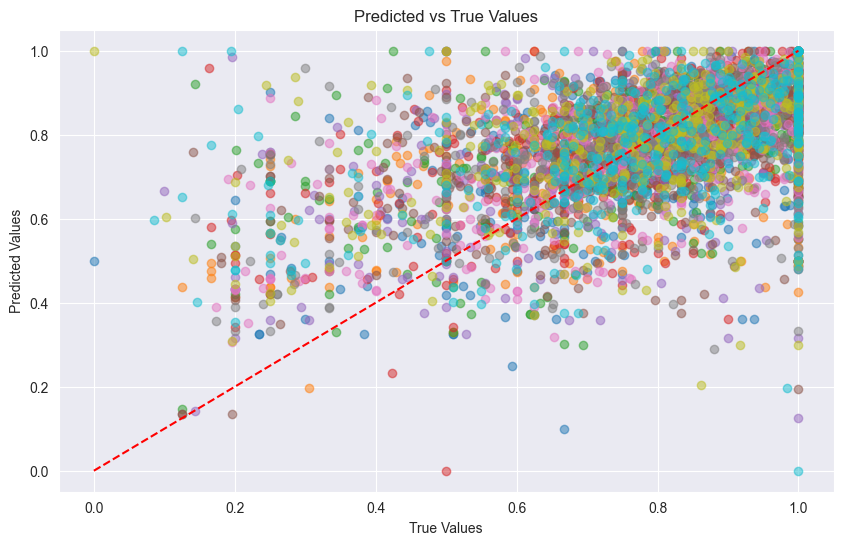

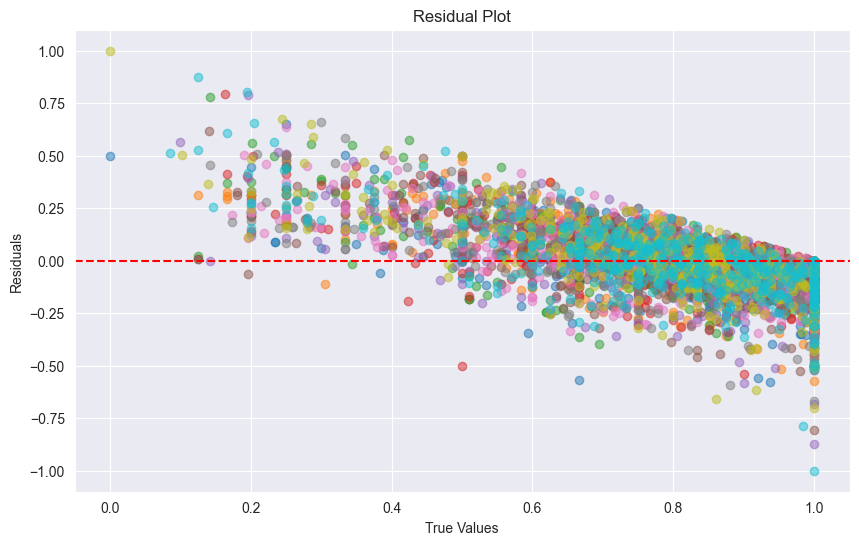

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assuming final_routes is your DataFrame
# Set a seed value for reproducibility
seed_value = 42
kf = KFold(n_splits=10, shuffle=True, random_state=seed_value)

final_routes = final_routes.sample(frac=1, random_state=42).reset_index(drop=True)

stats = []

for train_index, test_index in kf.split(final_routes, final_routes['score']):
    train_df = final_routes.iloc[train_index]
    test_df = final_routes.iloc[test_index]

    # Calculate the average scores on the training set
    average_scores = train_df.groupby(['driver_id_sorted', 'day_of_week'])['score'].mean().reset_index()
    average_scores_dict = average_scores.set_index(['driver_id_sorted', 'day_of_week'])['score'].to_dict()

    overall_average_scores = train_df.groupby('driver_id_sorted')['score'].mean().to_dict()
    # print(train_df.groupby('driver_id_sorted')[['driver_id_sorted']].apply(lambda x: pd.Series({
    # 'driver_id_sorted': len(x['driver_id_sorted'].tolist())})))


    #Apply the calculated average scores to both the training and testing data
    train_df['average_score'] = train_df.apply(lambda row: average_scores_dict.get((row['driver_id_sorted'], row['day_of_week'])), axis=1)
    test_df.loc[:, 'average_score'] = test_df.apply(lambda row: average_scores_dict.get((row['driver_id_sorted'], row['day_of_week']), overall_average_scores.get(row['driver_id_sorted'], 0.5)), axis=1)


    #Prepare the true and predicted values
    y_pred = test_df['average_score'].values
    y_true = test_df['score'].values

    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    stats.append({
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "y": y_true,
        "y_pred": y_pred
    })

# Function to calculate the mean of a specific metric from the stats
def get_mean_stat(stats, stat_name):
    arr = np.array([item[stat_name] for item in stats])
    return arr.mean()

# Print the mean metrics across all folds
print('mse:', get_mean_stat(stats, 'mse'))
print('rmse:', get_mean_stat(stats, 'rmse'))
print('mae:', get_mean_stat(stats, 'mae'))
print('r2:', get_mean_stat(stats, 'r2'))

# Visualization: Predicted vs True Values
plt.figure(figsize=(10, 6))
for stat in stats:
    plt.scatter(stat['y'], stat['y_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

# Visualization: Residual Plot
plt.figure(figsize=(10, 6))
for stat in stats:
    residuals = np.array(stat['y_pred']) - np.array(stat['y'])
    plt.scatter(stat['y'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


# After benchmark, continue model

In [23]:
final_routes['day_of_week_encoded'] = pd.Categorical(final_routes['day_of_week']).codes+1

def encode_day_of_week(row):
    a = np.zeros((35, 7), dtype=int)
    route_len = row['len']
    day_encoded = row['day_of_week_encoded']
    for i in range(35 - route_len, len(a)):
        a[i][day_encoded-1] = 1
    return a

final_routes['experience_feature'] = final_routes.apply(lambda x: x['len'] * [x['last_two_weeks_count']], axis = 1)
final_routes['len_feature'] = final_routes.apply(lambda x: x['len'] * [x['len']], axis = 1)
final_routes['driver_id_feature'] = final_routes.apply(lambda x: x['len'] * [x['driver_id_sorted']], axis = 1)
final_routes['day_of_week_feature'] = final_routes.apply(encode_day_of_week, axis = 1)

In [24]:
len(location_count)

2967

In [25]:
encoding_routes = []
for row in final_routes['routes']:
    encoding_route = []
    for location in row:
        encoding_route.append(locations_dic[location])
    encoding_routes.append(encoding_route)
final_routes['routes'] = encoding_routes


In [26]:
final_routes

,routes,actual_routes,driver_id,last_two_weeks_count,day_of_week,distance_route,score,len,driver_id_sorted,day_of_week_encoded,experience_feature,len_feature,driver_id_feature,day_of_week_feature
0,"[1, 1152, 1279, 1278, 1384, 1160, 1156, 1072, ...","[878, 2289, 2291, 2216, 2370, 1946, 1978, 1990...",1337,5,Monday,"[28.724525164283847, 10.919278164364068, 8.813...",0.593750,16,45,2,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 4...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
1,"[209, 214, 724, 220, 211, 211, 211, 226, 219, ...","[257, 259, 297, 295, 295, 308, 295, 270, 277, ...",1270,10,Wednesday,"[0.7537883663490852, 1.6251079693889117, 1.595...",0.883333,11,52,7,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]","[52, 52, 52, 52, 52, 52, 52, 52, 52, 52, 52]","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
2,"[1, 614, 1320, 612, 610, 609, 611, 611, 943, 9...","[878, 2055, 2018, 2018, 2050, 2054, 2013, 2031...",1283,8,Tuesday,"[20.444392042106408, 2.0630125027401958, 0.318...",0.805556,19,51,6,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 1...","[51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 5...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
3,"[431, 1, 546, 553, 547, 547, 549, 548, 557, 13...","[886, 878, 954, 961, 870, 870, 747, 711, 987, ...",1443,10,Thursday,"[0.10444204668193546, 8.580778599793824, 0.079...",0.726562,16,46,5,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 1...","[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 4...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
4,"[1, 644, 548, 549, 549, 554, 547, 547, 552, 12...","[878, 697, 746, 747, 746, 1010, 870, 870, 864,...",1443,9,Monday,"[7.119180601789166, 2.5281309460724035, 0.1174...",0.833333,18,46,2,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 4...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787,"[1, 1406, 1507, 5, 1605, 2701, 511, 861, 593, ...","[878, 1015, 1113, 1171, 1216, 1151, 1175, 1175...",1196,7,Tuesday,"[16.213269379555836, 0.7963340785188636, 1.131...",0.738095,13,49,6,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]","[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 4...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
4788,"[209, 633, 209, 965, 964, 964, 964, 1168, 921,...","[257, 342, 257, 234, 224, 224, 239, 224, 225, ...",1264,5,Thursday,"[7.360448052066768, 7.360448052066768, 8.68290...",0.846939,14,63,5,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]","[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 1...","[63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 6...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
4789,"[1626, 1626, 2231, 1858, 1859, 1860, 1860, 275...","[2294, 2294, 2647, 2698, 2698, 2638, 2639, 270...",1520,9,Thursday,"[0.0, 6.7770600523048685, 0.6216900103739094, ...",0.820513,25,161,5,"[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ...","[25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 2...","[161, 161, 161, 161, 161, 161, 161, 161, 161, ...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."
4790,"[1, 495, 495, 495, 1150, 496, 494, 498, 411, 4...","[878, 1461, 1461, 1461, 1354, 1462, 1384, 1469...",1227,10,Thursday,"[17.42793025061825, 0.0, 0.0, 1.09510192806930...",0.857143,15,41,5,"[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 1...","[15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1...","[41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 4...","[[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0],..."


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Assuming final_routes dataframe and relevant imports are available
o_test_df = final_routes[['driver_id_sorted', 'day_of_week_encoded', 'score']]
o_day_of = pd.get_dummies(o_test_df['day_of_week_encoded'])
o_driver = pd.get_dummies(o_test_df['driver_id_sorted'])
o_y = o_test_df['score']
o_train_df = pd.concat([o_day_of, o_driver], axis=1).astype(int)

kf = KFold(n_splits=10)

mse_list = []
rmse_list = []
mae_list = []
r2_list = []

for train_index, test_index in kf.split(o_train_df):
    o_x_train, o_x_test = o_train_df.iloc[train_index], o_train_df.iloc[test_index]
    o_y_train, o_y_test = o_y.iloc[train_index], o_y.iloc[test_index]

    model = RandomForestRegressor()
    model.fit(o_x_train, o_y_train)

    y_pred = model.predict(o_x_test)
    y_true = o_y_test

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# Average metrics across all folds
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_r2 = np.mean(r2_list)

print(f"MSE: {mean_mse}")
print(f"RMSE: {mean_rmse}")
print(f"MAE: {mean_mae}")
print(f"R2: {mean_r2}")
print(model.feature_importances_)

MSE: 0.026414071402537088
RMSE: 0.1623456446515893
MAE: 0.11959746229050608
R2: 0.25943001088971124
[2.93725924e-02 3.85751055e-02 1.70534868e-02 9.87641668e-03
 3.48686300e-02 3.76376895e-02 3.69096112e-02 1.68044447e-03
 1.95502185e-02 1.06808559e-02 3.50294666e-02 8.79318190e-02
 4.89200377e-02 1.54491782e-02 3.86725807e-02 3.14127948e-02
 9.79493709e-03 4.03023986e-02 2.34699325e-03 1.48322309e-03
 4.71718658e-03 1.48880185e-03 1.66585410e-03 3.98279569e-04
 2.97315800e-03 4.11109707e-03 2.56432283e-03 3.45386890e-03
 2.69426963e-03 1.91185857e-02 4.06116219e-03 1.94616620e-04
 2.97357986e-03 9.49309546e-04 1.89601132e-03 2.04877128e-03
 2.05984099e-03 4.68942184e-03 1.94187385e-03 1.63993773e-03
 4.13916619e-03 2.29044174e-03 1.41041306e-03 2.96566213e-03
 3.15284752e-03 2.01021772e-03 2.53997900e-03 1.14760698e-03
 1.26465575e-02 3.15829696e-03 6.22685366e-03 2.42148524e-03
 3.12150423e-03 5.40028622e-03 3.30442748e-03 3.36494743e-03
 1.72323057e-03 1.45325355e-03 5.26316764e-03 

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd

# Assuming final_routes dataframe and relevant imports are available
o_test_df = final_routes[['driver_id_sorted', 'day_of_week_encoded', 'score']]
o_day_of = pd.get_dummies(o_test_df['day_of_week_encoded'])
o_driver = pd.get_dummies(o_test_df['driver_id_sorted'])
o_y = o_test_df['score'].values
o_train_df = pd.concat([o_day_of, o_driver], axis=1).astype(int).values

kf = KFold(n_splits=10)

mse_list = []
rmse_list = []
mae_list = []
r2_list = []

class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# Training settings
num_epochs = 100
learning_rate = 0.001

for train_index, test_index in kf.split(o_train_df):
    o_x_train, o_x_test = o_train_df[train_index], o_train_df[test_index]
    o_y_train, o_y_test = o_y[train_index], o_y[test_index]

    # Convert to PyTorch tensors
    o_x_train = torch.tensor(o_x_train, dtype=torch.float32)
    o_x_test = torch.tensor(o_x_test, dtype=torch.float32)
    o_y_train = torch.tensor(o_y_train, dtype=torch.float32).view(-1, 1)
    o_y_test = torch.tensor(o_y_test, dtype=torch.float32).view(-1, 1)

    model = SimpleNN(o_x_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(o_x_train)
        loss = criterion(outputs, o_y_train)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred = model(o_x_test)
        y_true = o_y_test

    y_pred = y_pred.numpy()
    y_true = y_true.numpy()

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

# Average metrics across all folds
mean_mse = np.mean(mse_list)
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_r2 = np.mean(r2_list)

print(f"MSE: {mean_mse}")
print(f"RMSE: {mean_rmse}")
print(f"MAE: {mean_mae}")
print(f"R2: {mean_r2}")

MSE: 0.02437860518693924
RMSE: 0.15598027408123016
MAE: 0.11713167279958725
R2: 0.31706839522866936


In [29]:
# unique_days = final_routes['day_of_week'].unique()
# day_of_week_encoded = pd.get_dummies(final_routes['day_of_week'], prefix='day_of_week')
# final_routes = pd.concat([final_routes, day_of_week_encoded], axis=1)
# final_routes

# Model

In [30]:
def padding_(routes, route_len):
    features = np.zeros((len(routes), route_len),dtype=np.float16)
    for ii, route in enumerate(routes):
        if len(route) != 0:
            features[ii, -len(route):] = np.array(route)[:route_len]
    return features

X = final_routes.drop(columns = ['driver_id', 'last_two_weeks_count', 'len', 'driver_id_sorted','day_of_week_encoded'])
max_route_length = max(len(item) for item in final_routes['routes'])
y = np.array(final_routes['score'])
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), X.to_numpy()[:,2:]], axis=1)
# X = np.concatenate([padding_(X['routes'], max_route_length),padding_(X['distance_route'], max_route_length), padding_(X['experience_feature'], max_route_length), padding_(X['len_feature'], max_route_length), padding_(X['driver_id_feature'], max_route_length)], axis=1)
# X = X.astype(np.float16)
# X = X.astype(int) #for boolean values, to converst from string to int
# final_routes

## List of features

routes
distance_route
experience_feature
len_feature
driver_id_feature

Total: 175


In [31]:
from torch.utils.data import Dataset, DataLoader
import torch
import random

seed_value = 42
device = "cpu"


g = torch.Generator()

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Additional steps if using DataLoaders (to ensure reproducibility in data loading)
torch.use_deterministic_algorithms(True)

def reset_random():
    g.manual_seed(seed_value)
    torch.manual_seed(seed_value)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [32]:
import torch #pytorch
import torch.nn as nn

In [33]:
class PredictionRNN(nn.Module):
    def __init__(self,no_layers,vocab_size, vocab_size_driv, vocab_size_len,hidden_dim,embedding_dim,embedding_dim_driv,embedding_dim_len, output_dim,additional_feature_count,drop_prob=0.5):
        super(PredictionRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.vocab_size_driv = vocab_size_driv
        self.vocab_size_len = vocab_size_len

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_driv = nn.Embedding(vocab_size_driv, embedding_dim_driv)
        self.embedding_len = nn.Embedding(vocab_size_len, embedding_dim_len)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           num_layers=no_layers, batch_first=True)
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)
        # embedding_dim_driv+2
        # self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
        #                    num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(drop_prob)
        self.fc_lstm = nn.Linear(self.hidden_dim, 64)
        # self.fc_static_1 = nn.Linear(embedding_dim_driv+7, 16)
        # self.fc_static_2 = nn.Linear(16, 16)

        # linear and sigmoid layer
        # self.fc = nn.Linear(self.hidden_dim + additional_feature_count, output_dim)
        # self.fc = nn.Linear(self.hidden_dim + embedding_dim_driv, output_dim) #withfeatures
        # self.fc = nn.Linear(embedding_dim_driv+7+1, 256)
        # self.fc = nn.Linear(80,16)
        self.fc = nn.Linear(64,16)
        self.layer2 = nn.Linear(16, 16)
        self.layer3 = nn.Linear(16, 1)
        self.relu = nn.ReLU()

        # self.fc = nn.Linear(36, output_dim)
        # self.fc = nn.Linear(1316, output_dim)
        # self.sig = nn.Sigmoid()

    def forward(self,x):
        batch_size = len(x['routes'])
        route_ids = x['routes'].int()
        # print(route_ids.shape, route_ids.max(), route_ids)
        embeds = self.embedding(route_ids)  # shape: B x S x Feature   since batch = True

        # get driver ids example
        driver_ids = x['driver_id_feature'].int()
        experience = x['experience_feature'].int()
        day_of_week_feature = x['day_of_week_feature'].int()
        distance_route_feature = x['distance_route'].int()
        # print('day_of_week', day_of_week.shape, day_of_week)
        # print('len_feature', len_feature, len_feature.shape)
        # raise 'error'
        # distance = x['distance_route'].int()
        # latitudes = x['current_lat'].int()
        # longtitudes = x['current_lng'].int()
        embedding_driv = self.embedding_driv(driver_ids)
        # embedding_len = self.embedding_len(len_feature)

        # experience.view(batch_size, max_route_length, 1)
        # all_static = torch.concatenate((embedding_driv, day_of_week_feature), dim=2)
        # torch.concatenate((embeds, distance_route_feature.view(batch_size, max_route_length, 1)),dim=2)
        lstm_out, _ = self.lstm(embeds)
        lstm_out = lstm_out.contiguous().view(batch_size, max_route_length, self.hidden_dim)
        out = self.dropout(lstm_out)
        out = self.fc_lstm(out)
        # out = torch.concatenate((out, all_embeds), dim=2)
        # out_static = self.fc_static_1(all_static)
        # out_static = self.dropout(self.fc_static_2(out_static))
        # out = self.fc(torch.concatenate((out, out_static), dim=2))
        out = self.fc(out)
        x = self.relu(out)
        x = self.relu(self.layer2(x))
        out = self.layer3(x)
        # print(out.shape)
        # sigmoid function
        # sig_out = self.sig(out)
        # print(sig_out.shape)

        # reshape to be batch_size first
        sig_out = out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        # print(sig_out.shape)
        return sig_out

In [34]:
def get_model():
    no_layers = 2
    vocab_size = 2969 #extra 1 for padding
    vocab_size_driv = 192
    vocab_size_len = 36 #extra 1 for padding
    embedding_dim = 64 #was 64
    embedding_dim_driv = 12 #was 64
    embedding_dim_len = 2 #was 64
    output_dim = 1
    hidden_dim = 128 #was 64


    model = PredictionRNN(no_layers,vocab_size, vocab_size_driv, vocab_size_len, hidden_dim,embedding_dim, embedding_dim_driv,embedding_dim_len, output_dim,len(drivers_dic),drop_prob=0.5)
    model.train()
    print(model)
    return model

In [35]:
# function to predict accuracy
# def acc(pred,label):
#     pred = torch.round(pred.squeeze())
#     return torch.sum(pred == label.squeeze()).item()

def rmse(pred, label):
    return torch.sqrt(torch.mean((pred.squeeze() - label.squeeze())**2))

# def get_precision(pred, label):
#     pred = torch.round(pred.squeeze())
#     true_positive = torch.sum((pred == 1) & (label.squeeze() == 1)).item()
#     false_positive = torch.sum((pred == 1) & (label.squeeze() == 0)).item()
#
#     if true_positive + false_positive == 0:
#         return 0.0, true_positive, false_positive  # Handle the case where there are no predicted positives
#
#     precision_value = true_positive / (true_positive + false_positive)
#     return precision_value, true_positive, false_positive

In [36]:
RUN_NAME = 'first_run_4'
def train_model(data, model, epochs = 10):
    train_loader, valid_loader = data
    lr=0.0005

    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    clip = 5
    valid_loss_min = np.Inf
    # train for some number of epochs
    epoch_tr_loss,epoch_vl_loss = [],[]
    epoch_tr_acc,epoch_vl_acc = [],[]
    epoch_tr_precision,epoch_vl_precision = [],[]
    # wandb.init(project='Route_classification', name=f'{run_name}')

    for epoch in range(epochs):
        train_losses = []
        train_rmse = 0.0
        model.train()
        for inputs, labels in train_loader:
            # print(labels)

            model.zero_grad()
            # print(inputs.shape, h[0].shape, h[1].shape)
            output = model(inputs)

            # calculate the loss and perform backprop
            # print(output, labels)
            # print(output.shape, labels.shape)
            loss = criterion(output.view(-1), labels.float())
            loss.backward()
            train_losses.append(loss.item())
            train_rmse += rmse(output,labels)
            #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
        val_losses = []
        val_rmse = 0.0
        model.eval()
        for inputs, labels in valid_loader:
                # inputs, labels = inputs.to(device), labels.to(device)
                output = model(inputs)
                val_loss = criterion(output.view(-1), labels.float())
                val_losses.append(val_loss.item())
                val_rmse += rmse(output,labels)

        epoch_train_loss = np.mean(train_losses)
        epoch_val_loss = np.mean(val_losses)

        epoch_tr_loss.append(epoch_train_loss)
        epoch_vl_loss.append(epoch_val_loss)
        epoch_train_rmse = train_rmse / len(train_loader)
        epoch_val_rmse = val_rmse / len(valid_loader)
        print(f'Epoch {epoch+1}')
        print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
        print(f'train_rmse : {epoch_train_rmse} val_rmse : {epoch_val_rmse}')

        if epoch_val_loss <= valid_loss_min:
            torch.save(model.state_dict(), f'{RUN_NAME}.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
            valid_loss_min = epoch_val_loss
        print(25*'==')

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def get_stats(model, data):
    model.eval()
    y_pred = []
    y = []
    for inputs, labels in data:
        y.extend(labels)
        results = model(inputs).detach()
        y_pred.extend(results)

    y = np.array(y)
    y_pred = np.array(y_pred)

    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "y": y,
        "y_pred":y_pred
    }


In [38]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=10, shuffle=True, random_state=seed_value)
stats = []

FEATURE_COLUMNS = ['routes', 'driver_id_feature','experience_feature', 'day_of_week_feature', 'distance_route']


class DataFrameDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        item = {}
        for col in FEATURE_COLUMNS:
            feature = self.df[col].iloc[idx]
            if isinstance(feature, list):
                feature = padding_([feature], max_route_length)[0]
            item[col] = feature
        item['score'] = self.df['score'].iloc[idx]
        return item, item['score']

def get_data_loaders(train_df, test_df):
    # create Tensor datasets
    train_data = DataFrameDataset(train_df)
    valid_data = DataFrameDataset(test_df)

    # dataloaders
    batch_size = 64

    # make sure to SHUFFLE your data
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, generator=g, worker_init_fn=seed_worker)
    return train_loader, valid_loader

shuffled_df = final_routes.sample(frac=1, random_state=42).reset_index(drop=True)

for train_index, test_index in kf.split(shuffled_df, shuffled_df['score']):
    train_df = shuffled_df.iloc[train_index]
    test_df = shuffled_df.iloc[test_index]

    train_loader, valid_loader = get_data_loaders(train_df, test_df)
    print(f'len(train_df) = {len(train_df)}, len(test_df) = {len(test_df)}')
    model = get_model()
    model.train()

    train_model((train_loader, valid_loader), model, epochs=25)
    model = get_model()
    model.load_state_dict(torch.load(f'{RUN_NAME}.pt'))
    stats.append(get_stats(model, valid_loader))

len(train_df) = 4312, len(test_df) = 480
PredictionRNN(
  (embedding): Embedding(2969, 64)
  (embedding_driv): Embedding(192, 12)
  (embedding_len): Embedding(36, 2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_lstm): Linear(in_features=128, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)
Epoch 1
train_loss : 0.22254665549296668 val_loss : 0.034067113883793354
train_rmse : 0.41003964718421815 val_rmse : 0.18387708200220754
Validation loss decreased (inf --> 0.034067).  Saving model ...
Epoch 2
train_loss : 0.04012741460738813 val_loss : 0.03476163977757096
train_rmse : 0.19962548431362775 val_rmse : 0.1859428737089666
Epoch 3
train_loss : 0.03882257810191197 val_loss : 0.033480040496215224
train_rmse : 0.19591303515004335 val_rmse : 0.182660516707

mse: 0.019691533833966435
rmse: 0.14017895751362422
mae: 0.10490107988283692
r2: 0.44963013705936306


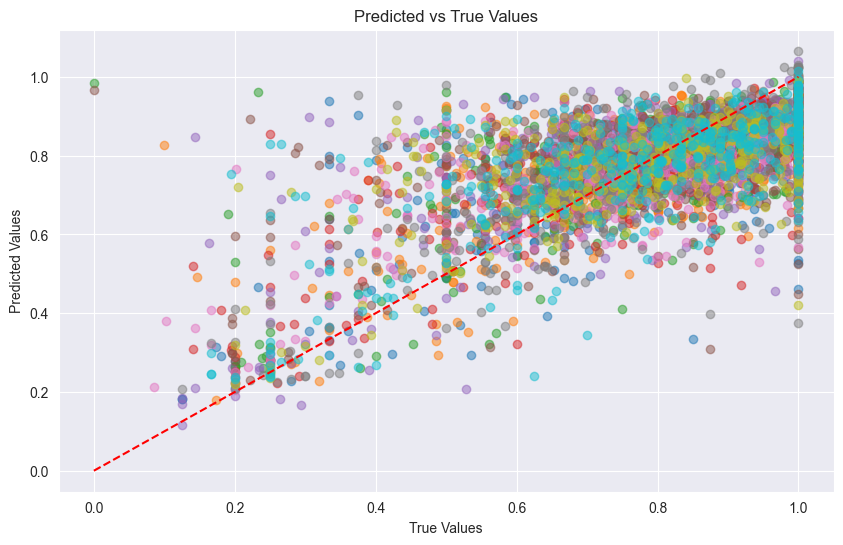

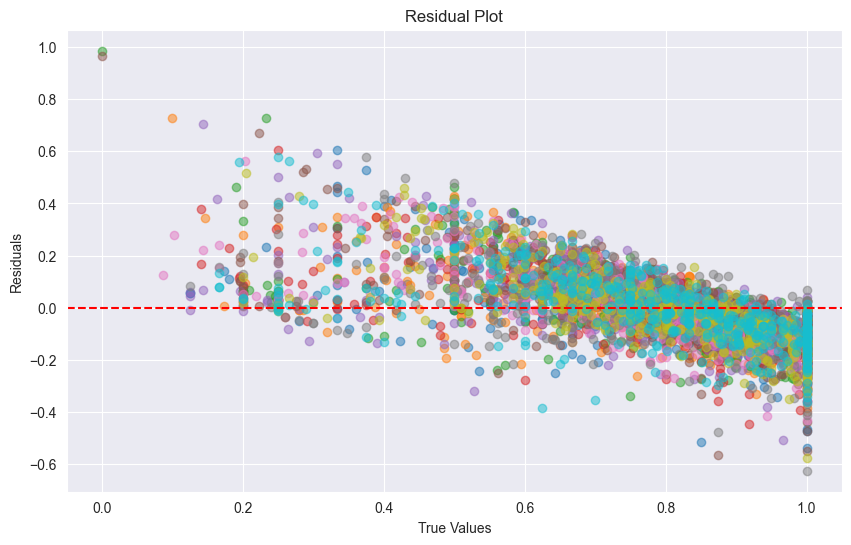

In [39]:
def get_mean_stat(stats, stat_name):
    # Calculate mean for regression stats
    arr = np.array([item[stat_name] for item in stats])
    return arr.mean()
print('mse:', get_mean_stat(stats, 'mse'))
print('rmse:', get_mean_stat(stats, 'rmse'))
print('mae:', get_mean_stat(stats, 'mae'))
print('r2:', get_mean_stat(stats, 'r2'))

# If you want to visualize the distribution of predictions vs actual values
plt.figure(figsize=(10, 6))
for stat in stats:
    plt.scatter(stat['y'], stat['y_pred'], alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

# If you want to visualize the residuals
plt.figure(figsize=(10, 6))
for stat in stats:
    residuals = np.array(stat['y_pred']) - np.array(stat['y'])
    plt.scatter(stat['y'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [40]:
# from sklearn.model_selection import train_test_split
#
# reset_random()
# X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, random_state=seed_value)
# train_loader, valid_loader = get_data_loaders(X_train, y_train, X_val, y_val)
#
# model = get_model()
# # summary(model, input_size=(1,9))
# model.train()
#
# train_model((train_loader, valid_loader), model, epochs=50)
#
# get_stats(model, valid_loader)

In [41]:
get_stats(model, valid_loader)
# def get_mean_stat(stats, stat_name) -> float:
#     return np.array([item[stat_name] for item in stats]).mean()
#
# print('acc:', get_mean_stat(stats, 'acc'))
# print('precision:', get_mean_stat(stats, 'precision'))
# print('recall:', get_mean_stat(stats, 'recall'))
# print('f1:', get_mean_stat(stats, 'f1'))
# print('roc_auc:', get_mean_stat(stats, 'roc_auc'))
# print('average_precision:', get_mean_stat(stats, 'average_precision'))

{'mse': 0.019258875313307625,
 'rmse': 0.13877634997832888,
 'mae': 0.10459570209265064,
 'r2': 0.5063344096978489,
 'y': array([0.56      , 0.73214286, 0.47619048, 0.83333333, 0.825     ,
        0.640625  , 0.88888889, 0.25      , 0.8       , 0.65277778,
        0.84      , 0.55555556, 0.63017751, 0.77777778, 0.78333333,
        0.80952381, 1.        , 0.75      , 0.66666667, 0.86607143,
        0.75      , 1.        , 0.98809524, 0.65      , 0.73809524,
        0.5       , 0.96666667, 0.65625   , 0.70238095, 0.75      ,
        0.97222222, 0.69387755, 0.71703297, 0.85714286, 0.58333333,
        0.75      , 0.88888889, 0.95454545, 0.76666667, 0.83333333,
        1.        , 0.195     , 0.62      , 0.55555556, 0.94642857,
        0.4       , 0.46875   , 0.815     , 1.        , 0.6875    ,
        0.36734694, 0.68181818, 0.90151515, 0.74      , 0.895     ,
        0.68      , 0.625     , 0.69642857, 0.91071429, 0.94      ,
        0.703125  , 0.92      , 0.91836735, 0.38888889, 0.61111

In [42]:
print(stats)

[{'mse': 0.020166968937785978, 'rmse': 0.14201045362150624, 'mae': 0.10527622263458868, 'r2': 0.41748211913430155, 'y': array([0.70909091, 0.92857143, 0.8       , 0.625     , 1.        ,
       1.        , 0.76893939, 0.97222222, 0.98484848, 0.7755102 ,
       0.77777778, 0.56666667, 0.79166667, 0.796875  , 0.55952381,
       0.77777778, 0.71666667, 0.95833333, 0.953125  , 0.8       ,
       1.        , 0.95679012, 0.67727273, 0.2       , 0.75      ,
       0.97222222, 0.78571429, 0.75      , 0.875     , 0.76785714,
       0.64197531, 0.86111111, 1.        , 0.88      , 0.85      ,
       0.4375    , 0.9375    , 0.90123457, 0.85714286, 0.56      ,
       0.86      , 0.375     , 0.79591837, 0.625     , 0.85714286,
       0.83673469, 0.86419753, 0.875     , 0.86419753, 0.67582418,
       1.        , 0.88888889, 0.71428571, 0.95918367, 0.71527778,
       0.875     , 0.82142857, 0.66666667, 1.        , 0.71428571,
       0.875     , 0.67901235, 0.65625   , 0.76      , 1.        ,
       0.

In [43]:
print(model.fc.weight)

Parameter containing:
tensor([[-0.0991,  0.0811, -0.0939,  ...,  0.0727,  0.0743,  0.0027],
        [-0.0411, -0.0610, -0.0884,  ..., -0.1325, -0.0239,  0.0905],
        [-0.0691,  0.0513, -0.0227,  ...,  0.0199, -0.0607, -0.0615],
        ...,
        [-0.0635,  0.0268, -0.0096,  ...,  0.0024, -0.1212, -0.0284],
        [-0.0864, -0.0647,  0.0473,  ...,  0.0050, -0.0518, -0.0292],
        [-0.0555, -0.0438, -0.0187,  ..., -0.0059, -0.0048,  0.0526]],
       requires_grad=True)


In [44]:
max([stat['r2'] for stat in stats]), min([stat['r2'] for stat in stats])

(0.5063344096978489, 0.3259196375396384)

In [45]:
[stat['r2'] for stat in stats]

[0.41748211913430155,
 0.4653835319331099,
 0.4388426841677123,
 0.4963366809696498,
 0.49212148149956947,
 0.3259196375396384,
 0.48365963481783747,
 0.4729623719031295,
 0.3972588189308335,
 0.5063344096978489]